In [1]:
import os
import numpy as np
import scipy.io as sio
from scipy.linalg import pinv
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.fftpack import dct
from tqdm import tqdm
from sklearn.linear_model import orthogonal_mp_gram
clear = lambda: os.system('cls' if os.name=='nt' else 'clear')
clear()

0

In [2]:
n = 192  # Length of signal
M=10000
cnt0 = cnt1 = cnt2 = cnt3 = cnt4 = cnt5 = cnt6 = cnt7 = cnt8 = 0 # Initialize counters

In [3]:
""" 
Load data from file
Extract data1 from data0
Extend data1 with additional values
Initializing TrainMat
"""


data0 = sio.loadmat('/home/debangshu/Downloads/Rec_ECG_MD_SD/Rec_ECG_MD_SD/traindataecg.mat')
# print(data0)
data1 = data0['A'][0, 0:9218*192]
data1 = np.concatenate((data1, data0['A'][0, 401: (9215*192) + 400]))

TrainMat0 = np.zeros((n, M))
TrainMat1 = np.zeros((n, M))
TrainMat2 = np.zeros((n, M))
TrainMat3 = np.zeros((n, M))
TrainMat4 = np.zeros((n, M))
TrainMat5 = np.zeros((n, M))
TrainMat6 = np.zeros((n, M))
TrainMat7 = np.zeros((n, M))
TrainMat8 = np.zeros((n, M))

In [4]:
""""""

for ii in range(0, 10000):
    train = data1[ii * n: (ii +1)* n] 
    mean_data = np.mean(np.abs(train))
    diff = np.abs(np.abs(train) - mean_data)
    Dif_th = diff > 300

    if np.sum(Dif_th) == 0:
        cnt0 += 1
        TrainMat0[:, cnt0 - 1] = train
    else:
        if np.sum(Dif_th[0:24]) > 0:
            cnt1 += 1
            TrainMat1[:, cnt1 - 1] = train
        elif np.sum(Dif_th[24:48]) > 0:
            cnt2 += 1
            TrainMat2[:, cnt2 - 1] = train
        elif np.sum(Dif_th[48:72]) > 0:
            cnt3 += 1
            TrainMat3[:, cnt3 - 1] = train
        elif np.sum(Dif_th[72:96]) > 0:
            cnt4 += 1
            TrainMat4[:, cnt4 - 1] = train
        elif np.sum(Dif_th[96:120]) > 0:
            cnt5 += 1
            TrainMat5[:, cnt5 - 1] = train
        elif np.sum(Dif_th[120:144]) > 0:
            cnt6 += 1
            TrainMat6[:, cnt6 - 1] = train
        elif np.sum(Dif_th[144:168]) > 0:
            cnt7 += 1
            TrainMat7[:, cnt7 - 1] = train
        elif np.sum(Dif_th[168:192]) > 0:
            cnt8 += 1
            TrainMat8[:, cnt8 - 1] = train

In [5]:
"""Assigning all the values in TrainMat[i] to 0.001"""

TrainMat0[:, :400] = np.where(TrainMat0[:, :400] == 0, 1, TrainMat0[:, :400])
TrainMat1[:, :400] = np.where(TrainMat1[:, :400] == 0, 1, TrainMat1[:, :400])
TrainMat2[:, :400] = np.where(TrainMat2[:, :400] == 0, 1, TrainMat2[:, :400])
TrainMat3[:, :400] = np.where(TrainMat3[:, :400] == 0, 1, TrainMat3[:, :400])
TrainMat4[:, :400] = np.where(TrainMat4[:, :400] == 0, 1, TrainMat4[:, :400])
TrainMat5[:, :400] = np.where(TrainMat5[:, :400] == 0, 1, TrainMat5[:, :400])
TrainMat6[:, :400] = np.where(TrainMat6[:, :400] == 0, 1, TrainMat6[:, :400])
TrainMat7[:, :400] = np.where(TrainMat7[:, :400] == 0, 1, TrainMat7[:, :400])
TrainMat8[:, :400] = np.where(TrainMat8[:, :400] == 0, 1, TrainMat8[:, :400])

In [6]:
def OMP(D, X, L):
    """
    Sparse coding of a group of signals based on a given dictionary and specified number of atoms to use.

    Parameters:
        D (numpy.ndarray): Dictionary matrix with shape (n, K). Columns must be normalized.
        X (numpy.ndarray): The signals to represent with shape (n, P).
        L (int): The maximum number of coefficients for each signal.

    Returns:
        A (scipy.sparse.csc_matrix): Sparse coefficient matrix with shape (K, P).
    """
    n, P = X.shape
    n, K = D.shape
    A = np.zeros((K, P))

    for k in range(P):
        a = np.zeros(L)
        
        x = X[:, k]
        residual = x
        indx = np.zeros(L, dtype=int)

        for j in range(L):
            proj = D.T @ residual
            pos = np.argmax(np.abs(proj))
            indx[j] = pos
            selected_atoms = D[:, indx[:j + 1]]
            a[:j + 1] = np.linalg.lstsq(selected_atoms, x, rcond=None)[0]
            residual = x - selected_atoms @ a[:j + 1]
            if np.sum(residual ** 2) < 1e-6:
                break

        temp = np.zeros(K)
        temp[indx[:j + 1]] = a[:j + 1]
        A[:, k] = temp

    return csc_matrix(A)

In [7]:
param = {}
param['K'] = 2 * n  # Number of atoms in dictionary
param['L'] = 1
param['numIteration'] = 10
param['errorFlag'] = 0
param['preserveDCAtom'] = 0
param['displayProgress'] = 0
param['InitializationMethod'] = 'DataElements'

In [8]:
dic = dct(np.eye(2 * n))
temp = np.random.permutation(2 * n)

Ovr_C_dic = dic[0:n, :]
param['TrueDictionary'] = Ovr_C_dic
iniMat = np.random.randn(n, param['K'])

for i in range(param['K']):
    iniMat[:, i] = iniMat[:, i] / np.linalg.norm(iniMat[:, i])  # Normalizing columns of the matrix

param['initialDictionary'] = iniMat

train = data0['A'][0, 0:600 * n]
l = 600  # Number of trained signals

TrainMat = np.zeros((n,l))   #initialising TrainMat
for i in range(0, l):
    TrainMat[:, i] = train[i  * n:(i+1) * n]
# print(TrainMat)  

In [9]:
def ksvd(Data, num_atoms, sparsity, initial_D=None,
    maxiter=10, etol=1e-10, approx=False, debug=True):
    """"        
        Data:       rows hold training data for dictionary fitting
        num_atoms:  number of dictionary atoms
        sparsity:   max sparsity of signals. Reduces to K-means
                    when sparsity=1
        initial_D:  if given, an initial dictionary. Otherwise, random
                    rows of data are chosen for initial dictionary
        maxiter:    maximum number of iterations
        err_thresh: stopping criteria; minimum residual
        approx:     True if using approximate KSVD update method.
                    Code runs faster if True, but results generally
                    in higher training error.
        
        Returns:
            D:               learned dictionary
            X:               sparse coding of input data
            error_norms:     array of training errors for each iteration
        Task: find best dictionary D to represent Data Y;
              minimize squared norm of Y - DX, constraining
              X to sparse codings.
    """
    # **implemented using column major order**
#     Data = Data.T

    assert Data.shape[1] > num_atoms # enforce this for now

    # intialization
    if initial_D is not None: 
        D = initial_D / np.linalg.norm(initial_D, axis=0)
        Y = Data
        X = np.zeros([num_atoms, Data.shape[1]])
    else:
        # randomly select initial dictionary from data
        idx_set = range(Data.shape[1])
        idxs = np.random.choice(idx_set, num_atoms, replace=False)    
        Y = Data[:,np.delete(idx_set, idxs)]
        X = np.zeros([num_atoms, Data.shape[1] - num_atoms])
        D = Data[:,idxs] / np.linalg.norm(Data[:,idxs], axis=0)

    # repeat until convergence or stopping criteria
    error_norms = []
    
    iterator = tqdm(range(1,maxiter+1)) if debug else range(1,maxiter+1)
    for iteration in iterator:
        # sparse coding stage: estimate columns of X
        gram = (D.T).dot(D)
        Dy = (D.T).dot(Y)
        X = orthogonal_mp_gram(gram, Dy, n_nonzero_coefs=sparsity)
        # codebook update stage
        for j in range(D.shape[1]):
            # index set of nonzero components
            index_set = np.nonzero(X[j,:])[0]
            if len(index_set) == 0:
                # for now, replace with some white noise
                if not approx:
                    D[:,j] = np.random.randn(*D[:,j].shape)
                    D[:,j] = D[:,j] / np.linalg.norm(D[:,j])
                continue
            # approximate K-SVD update
            if approx:
                E = Y[:,index_set] - D.dot(X[:,index_set])
                D[:,j] = E.dot(X[j,index_set])     # update D
                D[:,j] /= np.linalg.norm(D[:,j])
                X[j,index_set] = (E.T).dot(D[:,j]) # update X
            else:
                # error matrix E
                E_idx = np.delete(range(D.shape[1]), j, 0)
                E = Y - np.dot(D[:,E_idx], X[E_idx,:])
                U,S,VT = np.linalg.svd(E[:,index_set])
                # update jth column of D
                D[:,j] = U[:,0]
                # update sparse elements in jth row of X    
                X[j,:] = np.array([
                    S[0]*VT[ 0,np.argwhere(index_set==n)[0][0] ]
                    if n in index_set else 0
                    for n in range(X.shape[1])])
        # stopping condition: check error        
        err = np.linalg.norm(Y-D.dot(X),'fro')
        error_norms.append(err)
        if err < etol:
            break
    return D,X, np.array(error_norms)

In [10]:
# """Combined Dictionary function will train all the dictionary and save it as .npy in local"""

# def combined_dic():
#     DicKSVD,_,_ = ksvd(TrainMat, 384, 1, maxiter=10)
#     DicKSVD0,_,_ = ksvd(TrainMat0[:,:400], 384, 1, maxiter=10)
#     DicKSVD1,_,_ = ksvd(TrainMat1[:,:400], 384, 1, maxiter=10)
#     DicKSVD2,_,_ = ksvd(TrainMat2[:,:400], 384, 1, maxiter=10)
#     DicKSVD3,_,_ = ksvd(TrainMat3[:,:400], 384, 1, maxiter=10)
#     DicKSVD4,_,_ = ksvd(TrainMat4[:,:400], 384, 1, maxiter=10)
#     DicKSVD5,_,_ = ksvd(TrainMat5[:,:400], 384, 1, maxiter=10)
#     DicKSVD6,_,_ = ksvd(TrainMat6[:,:400], 384, 1, maxiter=10)
#     DicKSVD7,_,_ = ksvd(TrainMat7[:,:400], 384, 1, maxiter=10)
#     DicKSVD8,_,_ = ksvd(TrainMat8[:,:400], 384, 1, maxiter=10)
#     ksvd_all = {
#     'DicKSVD': DicKSVD,
#     'DicKSVD0': DicKSVD0,
#     'DicKSVD1': DicKSVD1,
#     'DicKSVD2': DicKSVD2,
#     'DicKSVD3': DicKSVD3,
#     'DicKSVD4': DicKSVD4,
#     'DicKSVD5': DicKSVD5,
#     'DicKSVD6': DicKSVD6,
#     'DicKSVD7': DicKSVD7,
#     'DicKSVD8': DicKSVD8,
#     }
#     for name, array in ksvd_all.items():
#         np.save(name + '.npy', array)
#     return DicKSVD, DicKSVD0, DicKSVD1, DicKSVD2, DicKSVD3, DicKSVD4, DicKSVD5, DicKSVD6, DicKSVD7, DicKSVD8


In [11]:
# runall=combined_dic()

In [12]:
print("Running the initial dictionary")
DicKSVD,_,e = ksvd(TrainMat, 384, 1, maxiter=10)

Running the initial dictionary


100%|███████████████████████████████████████| 10/10 [00:08<00:00,  1.24it/s]


In [21]:
DicKSVD0,_,_ = ksvd(TrainMat0[:,:400], 384, 1, maxiter=10)

100%|███████████████████████████████████████| 10/10 [00:00<00:00, 19.59it/s]


In [23]:
DicKSVD1,_,_ = ksvd(TrainMat1[:,:400], 384, 1, maxiter=10)

100%|███████████████████████████████████████| 10/10 [00:00<00:00, 17.74it/s]


In [25]:
DicKSVD2,_,_ = ksvd(TrainMat2[:,:400], 384, 1, maxiter=10)

100%|███████████████████████████████████████| 10/10 [00:00<00:00, 18.14it/s]


In [26]:
DicKSVD3,_,_ = ksvd(TrainMat3[:,:400], 384, 1, maxiter=10)

100%|███████████████████████████████████████| 10/10 [00:00<00:00, 21.58it/s]


In [29]:
DicKSVD4,_,_ = ksvd(TrainMat4[:,:400], 384, 1, maxiter=10)

100%|███████████████████████████████████████| 10/10 [00:00<00:00, 22.64it/s]


In [31]:
DicKSVD5,_,_ = ksvd(TrainMat5[:,:400], 384, 1, maxiter=10)

100%|███████████████████████████████████████| 10/10 [00:00<00:00, 24.02it/s]


In [34]:
DicKSVD6,_,_ = ksvd(TrainMat6[:,:400], 384, 1, maxiter=10)

100%|███████████████████████████████████████| 10/10 [00:00<00:00, 19.42it/s]


In [43]:
DicKSVD7,_,_ = ksvd(TrainMat7[:,:400], 384, 1, maxiter=10)

100%|███████████████████████████████████████| 10/10 [00:00<00:00, 19.20it/s]


In [48]:
DicKSVD8,_,_ = ksvd(TrainMat8[:,:400], 384, 1, maxiter=10)

100%|███████████████████████████████████████| 10/10 [00:00<00:00, 20.41it/s]


In [49]:

# target_files = ['DicKSVD.npy','DicKSVD0.npy','DicKSVD1.npy','DicKSVD2.npy','DicKSVD3.npy',
#                'DicKSVD4.npy','DicKSVD5.npy','DicKSVD6.npy','DicKSVD7.npy','DicKSVD8.npy',]
# current_directory = os.getcwd()

# for target_file in target_files:
#     npy_file_present = os.path.exists(os.path.join(current_directory, target_file))
    
#     if npy_file_present:
#         print(f"{target_file} is present in the directory.")
#         if target_file == 'DicKSVD.npy':
#             DicKSVD = np.load("DicKSVD.npy")
#         elif target_file == 'DicKSVD0.npy':
#             DicKSVD0 = np.load("DicKSVD0.npy")
#         elif target_file == 'DicKSVD1.npy':
#             DicKSVD1 = np.load("DicKSVD1.npy")
#         elif target_file == 'DicKSVD2.npy':
#             DicKSVD2 = np.load("DicKSVD2.npy")
#         elif target_file == 'DicKSVD3.npy':
#             DicKSVD3 = np.load("DicKSVD3.npy")
#         elif target_file == 'DicKSVD4.npy':
#             DicKSVD4 = np.load("DicKSVD4.npy")
#         elif target_file == 'DicKSVD5.npy':
#             DicKSVD5 = np.load("DicKSVD5.npy")
#         elif target_file == 'DicKSVD6.npy':
#             DicKSVD6 = np.load("DicKSVD6.npy")
#         elif target_file == 'DicKSVD7.npy':
#             DicKSVD7 = np.load("DicKSVD7.npy")
#         elif target_file == 'DicKSVD8.npy':
#             DicKSVD8 = np.load("DicKSVD8.npy")
            
            
#     else:
#         print(f"{target_file} is not present in the directory.")
#         if target_file == 'DicKSVD.npy':
#             DicKSVD,_,_ = ksvd(TrainMat, 384, 1, maxiter=10)
#             np.save('DicKSVD'+'.npy',DicKSVD)
#             DicKSVD = np.load("DicKSVD.npy")

#         elif target_file == 'DicKSVD0.npy':
#             DicKSVD0,_,_ = ksvd(TrainMat0, 384, 1, maxiter=10)
#             np.save('DicKSVD'+'.npy',DicKSVD)
#             DicKSVD = np.load("DicKSVD.npy")
#         elif target_file == 'DicKSVD1.npy':
#             DicKSVD1,_,_ = ksvd(TrainMat1, 384, 1, maxiter=10)
#             np.save('DicKSVD'+'.npy',DicKSVD)
#             DicKSVD = np.load("DicKSVD.npy")
#         elif target_file == 'DicKSVD2.npy':
#             DicKSVD2,_,_ = ksvd(TrainMat2, 384, 1, maxiter=10)
#             np.save('DicKSVD'+'.npy',DicKSVD)
#             DicKSVD = np.load("DicKSVD.npy")
#         elif target_file == 'DicKSVD3.npy':
#             DicKSVD3,_,_ = ksvd(TrainMat3, 384, 1, maxiter=10)
#             np.save('DicKSVD'+'.npy',DicKSVD)
#             DicKSVD = np.load("DicKSVD.npy")
#         elif target_file == 'DicKSVD4.npy':
#             DicKSVD4,_,_ = ksvd(TrainMat4, 384, 1, maxiter=10)
#             np.save('DicKSVD'+'.npy',DicKSVD)
#             DicKSVD = np.load("DicKSVD.npy")
#         elif target_file == 'DicKSVD5.npy':
#             DicKSVD5,_,_ = ksvd(TrainMat5, 384, 1, maxiter=10)
#             np.save('DicKSVD'+'.npy',DicKSVD)
#             DicKSVD = np.load("DicKSVD.npy")
#         elif target_file == 'DicKSVD6.npy':
#             DicKSVD6,_,_ = ksvd(TrainMat6, 384, 1, maxiter=10)
#             np.save('DicKSVD'+'.npy',DicKSVD)
#             DicKSVD = np.load("DicKSVD.npy")
#         elif target_file == 'DicKSVD7.npy':
#             DicKSVD7,_,_ = ksvd(TrainMat7, 384, 1, maxiter=10)
#             np.save('DicKSVD'+'.npy',DicKSVD)
#             DicKSVD = np.load("DicKSVD.npy")
#         elif target_file == 'DicKSVD8.npy':
#             DicKSVD8,_,_ = ksvd(TrainMat8, 384, 1, maxiter=10)
#             np.save('DicKSVD'+'.npy',DicKSVD)
#             DicKSVD = np.load("DicKSVD.npy")

In [51]:
# Load data
data0 = sio.loadmat('/home/debangshu/Downloads/Rec_ECG_MD_SD/Rec_ECG_MD_SD/1.mat') # contains val: [2x21600 double]
temp= data0['s']

train_data = temp[1,:];
# import pandas as pd 
# data = pd.read_csv("/home/debangshu/Downloads/Dataset_1.csv")
# train_data = data["ECG"]
N = 192
k = 64      # sparsity
M = 500

Phi = (1/np.sqrt(M))*np.random.randn(M, N)
Y = np.empty((10*M, 1))
for ii in range(10):
    train = train_data[(ii*N):(ii+1)*N]
    x = train.T
    
    y1 = Phi @ x
    
    Y[ii*M:(ii+1)*M] = y1.reshape((M,1))
    
    
def OMP(D, X, L):
    """
    Sparse coding of a group of signals based on a given dictionary and specified
    number of atoms to use.

    Arguments:
    D -- the dictionary (its columns MUST be normalized)
    X -- the signals to represent
    L -- the max. number of coefficients for each signal

    Returns:
    A -- sparse coefficient matrix
    """

    P, n = X.shape
    n, K = D.shape
    A = np.zeros((K, P))

    for kk in range(P):
        a = np.array([])
        x = X[ kk, :]
        residual = x
        indx = np.zeros(L, dtype=int)
        for j in range(L):
            proj = np.dot(D.T, residual)
            pos = np.argmax(np.abs(proj))
            indx[j] = pos
            a = np.dot(pinv(D[:, indx[:j+1]]), x)
            residual = x - np.dot(D[:, indx[:j+1]], a)
            if np.sum(residual**2) < 1e-6:
                break
        temp = np.zeros(K)
        temp[indx[:j+1]] = a
        A =csr_matrix(temp)
    
    return A



X_Rec=np.zeros((10*N,1))

for jj in range(10):
    y = Y[(jj)*M : (jj+1)*M].T
    
    Psi = DicKSVD
    AA = Phi @ Psi
    x_rec = OMP(AA, y, k)
    x_rec = Psi @ x_rec.T
    
    mean_data = np.mean(np.abs(x_rec))
    diff = np.abs(np.abs(x_rec) - mean_data)
    Dif_th = diff > 300
    
    if np.sum(Dif_th) == 0:
        Psi = DicKSVD0
        AA = Phi @ Psi
        x_rec1 = OMP(AA, y, k)
        x_final1 = Psi @ x_rec1.T
    else:
        if np.sum(Dif_th[0:24]) > 0:
            Psi = DicKSVD1
        elif np.sum(Dif_th[24:48]) > 0:
            Psi = DicKSVD2
        elif np.sum(Dif_th[48:72]) > 0:
            Psi = DicKSVD3
        elif np.sum(Dif_th[72:96]) > 0:
            Psi = DicKSVD4
        elif np.sum(Dif_th[96:120]) > 0:
            Psi = DicKSVD5
        elif np.sum(Dif_th[120:144]) > 0:
            Psi = DicKSVD6
        elif np.sum(Dif_th[144:168]) > 0:
            Psi = DicKSVD7
        elif np.sum(Dif_th[168:192]) > 0:
            Psi = DicKSVD8
            
        AA = Phi @ Psi
        x_rec1 = OMP(AA, y, k)
        x_final1 = Psi @ x_rec1.T
    
    X_Rec[jj*N : (jj+1)*N,:] = x_final1
    
org = train_data[0:10*N]

Text(0.5, 1.0, 'Original signal')

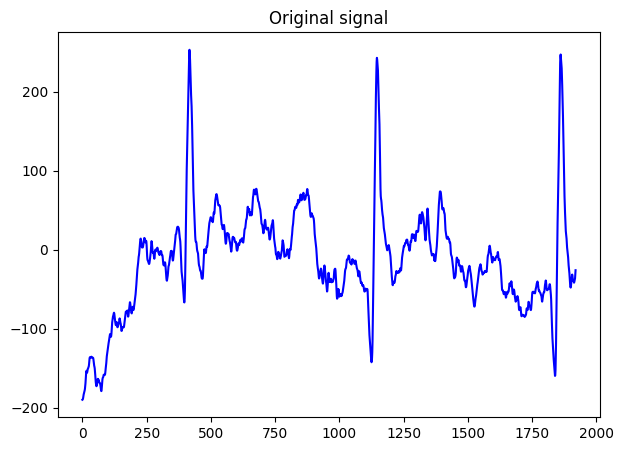

In [62]:
plt.figure(figsize=(7,5))
plt.plot(org, 'b')
plt.title( "Original signal")

Text(0.5, 1.0, 'Reconstructed signal')

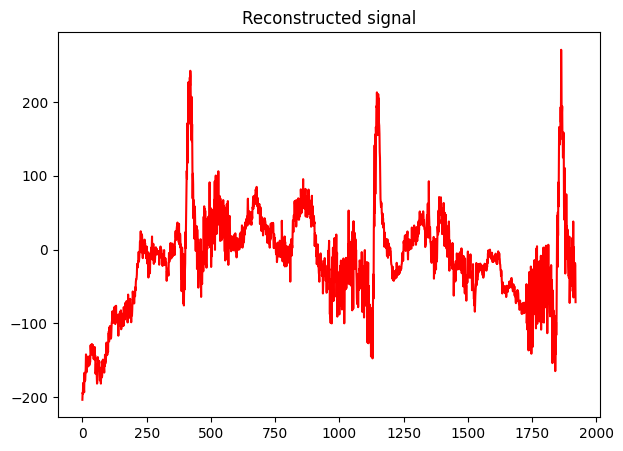

In [58]:

plt.figure(figsize=(7,5))
plt.plot(X_Rec, 'r')
plt.title("Reconstructed signal")


In [55]:
print(org)
print(X_Rec)

[-190.  -189.8 -189.  ...  -36.3  -31.8  -26. ]
[[-203.79936693]
 [-193.93313547]
 [-195.93539366]
 ...
 [ -18.13500429]
 [ -21.82216716]
 [ -71.35110864]]
